# PINF

## 0. Hyperparameters

In [1]:
import torch
import numpy as np
import imageio.v2 as imageio
import cv2
import argparse
import json
import os
from typing import Tuple

In [2]:
args = {
    'config': 'configs/scalar.txt',
    'expname': 'scalar_test1',
    'basedir': './log',
    'datadir': './data/ScalarReal',
    'net_model': 'siren',
    'netdepth': 8,
    'netwidth': 256,
    'netdepth_fine': 8,
    'netwidth_fine': 256,
    'N_rand': 1024,
    'lrate': 0.0005,
    'lrate_decay': 500,
    'chunk': 32768,
    'netchunk': 65536,
    'no_batching': True,
    'no_reload': False,
    'ft_path': None,
    'fix_seed': 42,
    'fading_layers': 50000,
    'tempo_delay': 0,
    'vel_delay': 10000,
    'N_iter': 600000,
    'train_warp': True,
    'bbox_min': '0.05',
    'bbox_max': '0.9',
    'vgg_strides': 4,
    'ghostW': 0.07,
    'vggW': 0.01,
    'overlayW': -0.0,
    'd2vW': 2.0,
    'nseW': 0.001,
    'vol_output_only': False,
    'vol_output_W': 128,
    'render_only': False,
    'render_test': False,
    'N_samples': 64,
    'N_importance': 64,
    'perturb': 1.0,
    'use_viewdirs': False,
    'i_embed': -1,
    'multires': 10,
    'multires_views': 4,
    'raw_noise_std': 0.0,
    'render_factor': 0,
    'precrop_iters': 1000,
    'precrop_frac': 0.5,
    'dataset_type': 'pinf_data',
    'testskip': 20,
    'shape': 'greek',
    'white_bkgd': True,
    'half_res': 'half',
    'factor': 8,
    'no_ndc': False,
    'lindisp': False,
    'spherify': False,
    'llffhold': 8,
    'i_print': 400,
    'i_img': 2000,
    'i_weights': 25000,
    'i_testset': 50000,
    'i_video': 50000
}
args = argparse.Namespace(**args)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device('cuda')
torch.set_default_dtype(torch.float32)

In [3]:
np.random.seed(args.fix_seed)
torch.manual_seed(args.fix_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.fix_seed)
    torch.backends.cudnn.deterministic = True

## 1. Load Data and Preprocess

In [4]:
def load_data_pinf(in_type: str, in_skip: int = 1):
    _all_images = []
    _all_poses = []
    _all_time_steps = []
    with open(os.path.normpath(os.path.join(args.datadir, 'info.json')), 'r') as fp:
        _meta = json.load(fp)
        for _video in _meta[in_type + '_videos']:
            _image_array = []
            _pose_array = []
            _time_step_array = []
            _f_name = os.path.normpath(os.path.join(args.datadir, _video['file_name']))
            _reader = imageio.get_reader(_f_name)
            _frame_num = _video['frame_num']
            _dt = 1. / _frame_num
            for _idx in range(0, _frame_num, in_skip):
                _reader.set_image_index(_idx)
                _image_array.append(_reader.get_next_data())
                _pose_array.append(_video['transform_matrix'])
                _time_step_array.append(_idx * _dt)
            _reader.close()
            _all_images.append((np.array(_image_array) / 255.).astype(np.float32))
            _all_poses.append(np.array(_pose_array).astype(np.float32))
            _all_time_steps.append(np.array(_time_step_array).astype(np.float32))
    return _all_images, _all_poses, _all_time_steps


all_images, all_poses, all_time_steps = load_data_pinf('train')

In [5]:
diff_images = np.abs(all_images[0][1:] - all_images[0][:-1])
diff_images_uint8 = (diff_images * 255).clip(0, 255).astype(np.uint8)
output_file = 'diff_images_uint8.mp4'
fps = 30
with imageio.get_writer(output_file, fps=fps) as writer:
    for frame in diff_images_uint8:
        writer.append_data(frame)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1080, 1920) to (1088, 1920) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


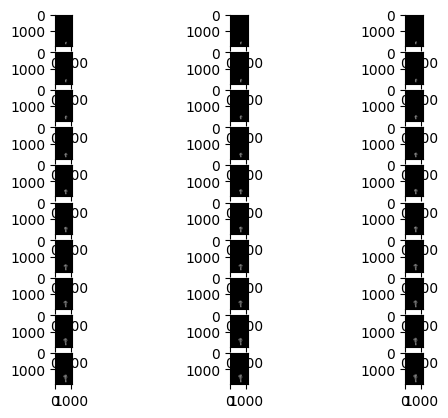

In [6]:
import matplotlib.pyplot as plt
frames = 30
for _ in range(frames):
    plt.subplot(10, frames // 10, _+1)
    plt.imshow(all_images[0][_])
plt.show()

## 2. Model

In [7]:
class SIREN(torch.nn.Module):
    def __init__(self, net_width: int, net_depth: int, input_channel: int, input_channel_views: int, skips: list):
        super(SIREN, self).__init__()

    def forward(self, points: torch.Tensor, views: torch.Tensor):
        pass